# Canny Edge Detector 

In [1]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
from scipy import ndimage

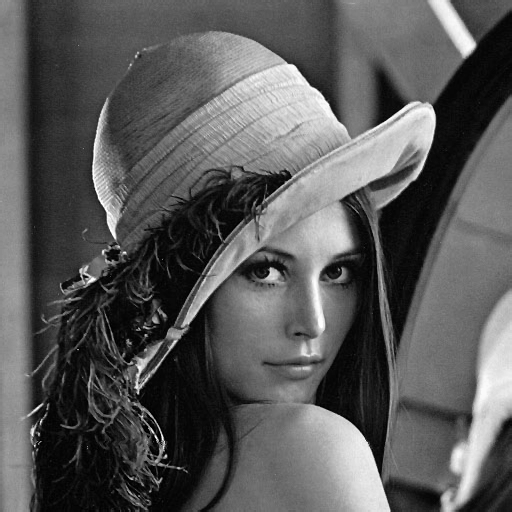

In [2]:
image = cv2.imread('lena.png')
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_img = gray_img.astype(np.float64)

cv2_imshow(gray_img)

##1. Apply gaussian filter

The first step is to smooth our image with a Gaussian filter to reduce noise in our image. Here, we'll be using the Gaussian filter provided by the cv2 library.

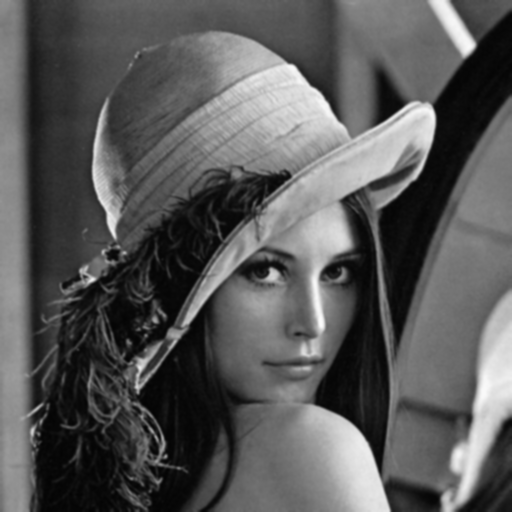

In [3]:
blur_img = cv2.GaussianBlur(gray_img, (5, 5), 0)

cv2_imshow(blur_img)

##2. Gradient Calculation

Next, we will detect edge intensity and edge directions by calculating the gradient of the image using Sobel edge detection operators.

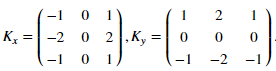

Our gradient intensity matrix and edge direction matrix are calculated with the following formulas:

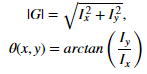

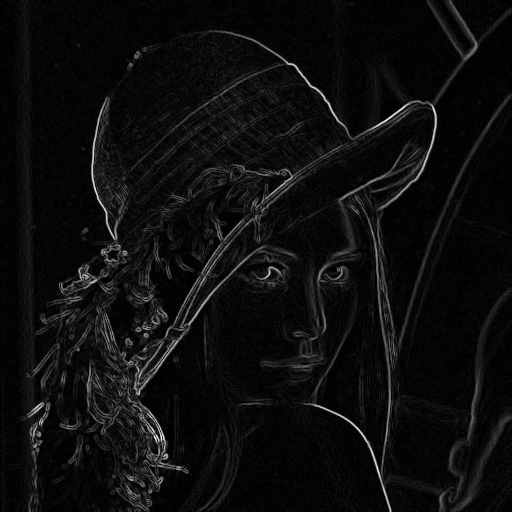

In [4]:
mask_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], np.float32)

mask_y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
], np.float32)

# Lakukan convolusi dengan function dari scipy.ndimage.filters
# Pertama lakukan convolusi secara vertikal menggunakan mask_x, lalu secara horizontal dengan mask_y
sobel_x = ndimage.filters.convolve(gray_img, mask_x)
sobel_y = ndimage.filters.convolve(gray_img, mask_y)

# Menghitung gradient intensity matrix
sobel_img = np.sqrt(sobel_x**2 + sobel_y**2)
sobel_img = sobel_img / sobel_img.max() * 255

# Menghitung edge directions dalam angle matrix
angles = np.arctan2(sobel_y, sobel_x)

cv2_imshow(sobel_img)

##3. Non-maximum Suppression

As we can see from the above image, there are a few edges that seem thicker than others. So, we will perform non-maximum suppression to thin out the thick edges.


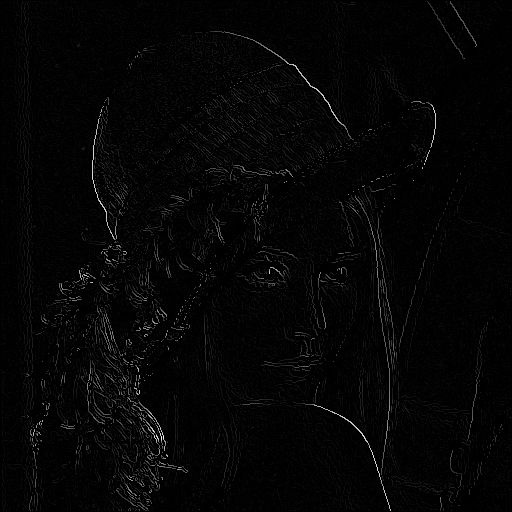

In [5]:
h, w = sobel_img.shape
result = np.zeros(sobel_img.shape, dtype=np.int32)

angle_matrix = angles * 180. / np.pi
# bagi sudut derajat yang bernilai negatif kita naikkan
angle_matrix[angle_matrix < 0] += 180

# Sekarang, kita loop through the image, visit semua point/pixel dalam gradient intensity matrix kita
for i in range(1, h-1):
  for j in range(1, w-1):
    q = 255
    r = 255

    # Jika nilai sudut edge adalah mendekati 0 (arah horizontal)
    if (0 <= angle_matrix[i,j] < 22.5) or (157.5 <= angle_matrix[i,j] <= 180):
      q = sobel_img[i, j+1]
      r = sobel_img[i, j-1] 
    # Jika nilai sudut edge adalah mendekati 45 (arah diagonal kanan /)
    elif (22.5 <= angle_matrix[i,j] < 67.5):
      q = sobel_img[i+1, j-1]
      r = sobel_img[i-1, j+1]
    # Jika nilai sudut edge adalah mendekati 90 (arah vertikal)
    elif (67.5 <= angle_matrix[i,j] < 112.5):
      q = sobel_img[i+1, j]
      r = sobel_img[i-1, j]
    # Jika nilai sudut edge adalah mendekati 135 (arah diagonal kiri \)
    elif (67.5 <= angle_matrix[i,j] < 112.5):
      q = sobel_img[i-1, j-1]
      r = sobel_img[i+1, j+1]

    # Cek apakah ada pixel sekitar (q atau r) yang lebih intens daripada p(i, j)
    if (sobel_img[i, j] >= q) and (sobel_img[i, j] >= r):
      # Jika p(i, j) adalah yang paling intens
      result[i, j] = sobel_img[i, j]
    else:
      result[i, j] = 0

cv2_imshow(result)

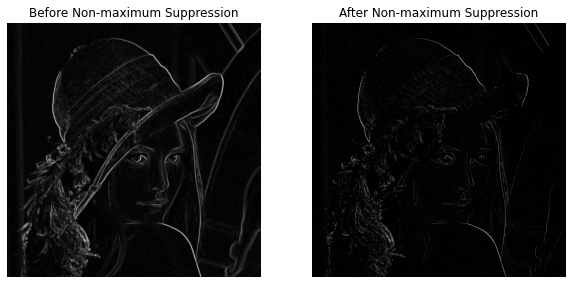

In [6]:
plt.figure(figsize=(10, 6))

plt.subplot(121)
plt.imshow(sobel_img, cmap='gray')
plt.title('Before Non-maximum Suppression')
plt.axis('off')

plt.subplot(122)
plt.imshow(result, cmap='gray')
plt.title('After Non-maximum Suppression')
plt.axis('off')

plt.show()

##4. Double Threshold

Now, since the edges have become thinner, we need to emphasize the strong pixels, dumb down the weak pixels, and throw away (set to 0) the non-relevant pixels. 

- Strong pixels are pixels that have an intensity so high that we are sure they contribute to the final edge.
- Weak pixels are pixels that have an intensity value that is not enough to be considered as strong ones, but yet not small enough to be considered as non-relevant for the edge detection.
- Other pixels are considered as non-relevant for the edge.

We will use two thresholds, high and low. Pixels that fall above the high threshold will be identified as a strong pixel. Pixels that fall below the low threshold will be identified as a non-relevant pixel. Lastly, pixels that fall between the two thresholds will be flagged as weak pixels. Hysteresis will help us further determine which weak pixels to turn to strong/non-relevant.

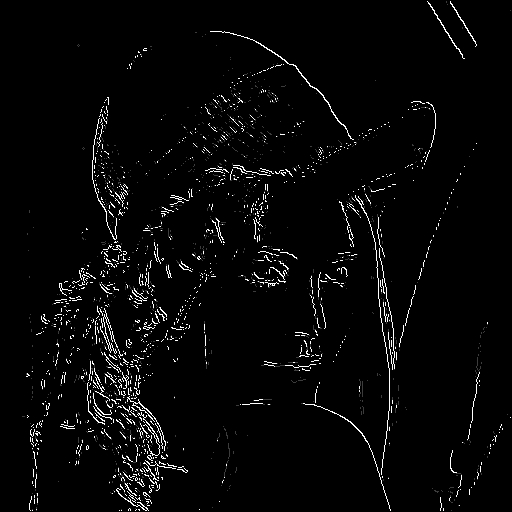

In [33]:
# Strong pixel adalah pixel dengan nilai >= 60
high_thresh = 40
# Non relevant pixel adalah pixel dengan nilai < 20
low_thresh = 30

h, w = result.shape
thresh_img = np.zeros((h, w), dtype=np.int32)

weak_flag = 60
strong_flag = 255

# Cari position of all strong pixels
strong_i, strong_j = np.where(result >= high_thresh)
# Cari position of not relevant pixels
not_relev_i, not_relev_j = np.where(result < low_thresh)
# Cari position of weak pixels
weak_i, weak_j = np.where((result < high_thresh) & (result >= low_thresh))

# Emphasize strong pixels
thresh_img[strong_i, strong_j] = strong_flag
# Tandai weak pixels
thresh_img[weak_i, weak_j] = weak_flag

cv2_imshow(thresh_img)

##5. Hysteresis

As we can see from the above image, there are a lot of weak pixels, and some of them should actually be strong pixels, like the pixels outlining the hat. Therefore, we need to fix the edges that are missing using hysteresis.

The concept of hysteresis is to transform a weak pixel into a strong pixel, if and only if, at least ONE of the pixels around it is a strong pixel.

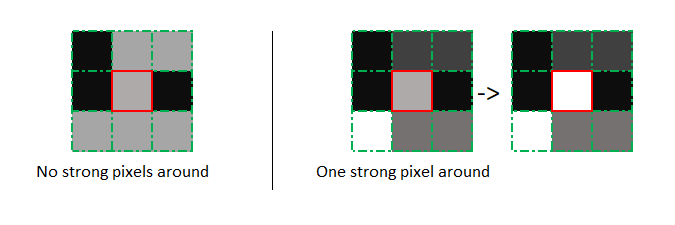

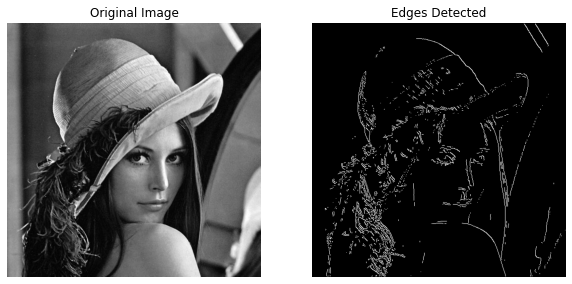

In [34]:
def has_strong_neighbour_pixel(img, i, j, strong):
  if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
      or (img[i, j-1] == strong) or (img[i, j+1] == strong)
      or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
    return True
  else:
    return False

h, w = thresh_img.shape
final_edges = thresh_img

for i in range(1, h-1):
  for j in range(1, w-1):
    if (thresh_img[i, j] == weak_flag):
      # Jika dia memiliki 1 strong neighbour pixel
      if has_strong_neighbour_pixel(thresh_img, i, j, strong_flag):
        # Identify it as strong
        final_edges[i, j] = strong_flag
      else:
        # Else matikan saja pixelnya
        final_edges[i, j] = 0

# Maka kita akan mendapatkan final_edges dengan pixel yang hanya terdiri dari 255 untuk edge
# dan 0 untuk background-nya
plt.figure(figsize=(10, 6))

plt.subplot(121)
plt.imshow(gray_img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(final_edges, cmap='gray')
plt.title('Edges Detected')
plt.axis('off')

plt.show()